<a href="https://colab.research.google.com/github/daniil-lyakhov/cv_text_classification/blob/main/translation_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install -U spacy -q
!python -m spacy download en_core_web_sm
!python -m spacy download ru_core_news_sm

     |████████████████████████████████| 6.0 MB 4.6 MB/s 
     |████████████████████████████████| 10.1 MB 24.3 MB/s 
     |████████████████████████████████| 181 kB 16.8 MB/s 
     |████████████████████████████████| 628 kB 33.0 MB/s 
     |████████████████████████████████| 42 kB 578 kB/s 
     |████████████████████████████████| 451 kB 32.5 MB/s 
     |████████████████████████████████| 13.9 MB 5.1 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 16.4 MB 51 kB/s 
     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 8.2 MB 9.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline

# Full dataset loading

ParaCrawl Rus-Eng dataset was choosen for experiments, link:
https://lindat.mff.cuni.cz/repository/xmlui/handle/11372/LRT-2610

In [ ]:
!wget "https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11372/LRT-2610/paracrawl-release1.en-ru.zipporah0-dedup-clean.tgz?sequence=9&isAllowed=y" -O out.tgz  

--2021-12-14 19:35:23--  https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11372/LRT-2610/paracrawl-release1.en-ru.zipporah0-dedup-clean.tgz?sequence=9&isAllowed=y
Resolving lindat.mff.cuni.cz (lindat.mff.cuni.cz)... 195.113.20.140
Connecting to lindat.mff.cuni.cz (lindat.mff.cuni.cz)|195.113.20.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 667981874 (637M) [application/x-gzip]
Saving to: ‘out.tgz’

out.tgz             100%[===================>] 637.04M  24.6MB/s    in 27s     

2021-12-14 19:35:51 (23.8 MB/s) - ‘out.tgz’ saved [667981874/667981874]



In [ ]:
!tar -xvf out.tgz

paracrawl-release1.en-ru.zipporah0-dedup-clean.en
paracrawl-release1.en-ru.zipporah0-dedup-clean.ru


In [ ]:
lines_eng = open('paracrawl-release1.en-ru.zipporah0-dedup-clean.en', 'r').readlines()
lines_rus = open('paracrawl-release1.en-ru.zipporah0-dedup-clean.ru', 'r').readlines()

In [ ]:
lines_rus[:10]

['Email: info@e-e-e.cz\n',
 'Фирма зарегистрирована в Городском суде в г. Праге, раздел Б, вкладыш 14857.\n',
 'Новости:\n',
 '22.02.09\n',
 'С января месяца 2009 г. открыты новые офисные помещения на улице V Kolkovně 3 (В Колковне, д. 3), Прага-1. Данные помещения находятся поблизости всех банков-партнеров.\n',
 'O НАС Новости Референции Контакт\n',
 'Новости\n',
 '02 / 2009\n',
 'Открыты новые офисные помещения (22. 02.)\n',
 'Компания АО «East Export Engineering» («EEE») исходит из успехов чешских фирм и банков в области экспортного финансирования; она поставила перед собой цель далее развивать поддержку финансирования чешских и зарубежных проектов с участием чешских фирм в качестве подрядчиков/поставщиков.\n']

In [ ]:
lines_eng[:10]

['E-mail: info@e-e-e.cz\n',
 'The company has been registered with the Municipal Court in Prague, in Section B, File 14857.\n',
 'News:\n',
 '22.02.09\n',
 'Since January 2009 new office premises in the street V Kolkovně 3, Prague 1, have been opened. These premises are situated in a close vicinity of all our partner banks.\n',
 'About us News References Contacts\n',
 'News\n',
 '02 / 2009\n',
 'New projects (22. 02.) New office premises have been opened (19. 02.)\n',
 'East Export Engineering a.s. (EEE) has reassumed the previous success of Czech companies and banks in the field of export financing and commenced its activity with the aim to further develop the support of financing of home and foreign schemes involving supplier participation of Czech companies.\n']

In [ ]:
len(lines_eng)

12061155

# EDA

Check elements length

In [ ]:
def get_statistics(lines_rus, lines_eng):
    lenghts = {}
    for data, key in [(lines_rus, 'rus'), (lines_eng, 'eng')]:
        lenghts[key] = np.array([len(sent) for sent in data], dtype=int)

    def collect_statistics(arr):
        res = {}
        res['mean'] = arr.mean()
        res['argmin'] = np.argmin(arr)
        res['argmax'] = np.argmax(arr)
        res['min'] = arr.min()
        res['max'] = arr.max()
        return res

    stat_rus = collect_statistics(lenghts['rus'])
    stat_eng = collect_statistics(lenghts['eng'])
    ratious = lenghts['rus'] / lenghts['eng']
    stat_ratious = collect_statistics(ratious)

    def get_pair(idx):
        return lines_eng[idx], lines_rus[idx]

    smallest = get_pair(stat_eng['argmin'])
    longest = get_pair(stat_eng['argmax'])
    smallest_ratio = get_pair(stat_ratious['argmin'])
    biggest_ratio = get_pair(stat_ratious['argmax'])

    len_stat_srt = f'Lenght statistics:\nRus:{stat_rus}\nEng{stat_eng}\nRus / Eng {stat_ratious}'
    extreems_ex_str = f'Pairs\nSmallest: {smallest}\n'\
                      f'Longest: {longest}\n'\
                      f'Smallest ratio: {smallest_ratio}\n'\
                      f'Biggest ratio: {biggest_ratio}'
                    
    counts = f'Counts of pairs: {len(lines_rus)}'
    descr = len_stat_srt + '\n' + extreems_ex_str + '\n' + counts
    retval = {}
    retval['rus'] = stat_rus
    retval['eng'] = stat_eng
    retval['ratious'] = ratious
    retval['len'] = lenghts

    return descr, retval

stats_init = get_statistics(lines_rus, lines_eng) 
print(stats_init[0])


Lenght statistics:
Rus:{'mean': 79.00969981730606, 'argmin': 677, 'argmax': 9573105, 'min': 2, 'max': 15554}
Eng{'mean': 82.27549426236543, 'argmin': 677, 'argmax': 9573105, 'min': 2, 'max': 15554}
Rus / Eng {'mean': 1.0397173034121685, 'argmin': 5459424, 'argmax': 7310074, 'min': 0.015503875968992248, 'max': 56.0}
Pairs
Smallest: ('?\n', '?\n')
Longest: ('\'))}},_connectDatepicker:function(b,f){var j=a(b);f.append=a([]);f.trigger=a([]);if(!j.hasClass(this.markerClassName)){this._attachments(j,f);j.addClass(this.markerClassName).keydown(this._doKeyDown).keypress(this._doKeyPress).keyup(this._doKeyUp).bind("setData.datepicker", function(l,o,n){f.settings[o]=n}).bind("getData.datepicker",function(l,o){return this._get(f,o)});this._autoSize(f);a.data(b,"datepicker",f);f.settings.disabled&&this._disableDatepicker(b)}},_attachments:function(b,f){var j=this._get(f,"appendText"),l=this._get(f,"isRTL");f.append&&f.append.remove();if(j){f.append=a(\' \'+j+" ");b[l?"before":"after"](f.append)}b.

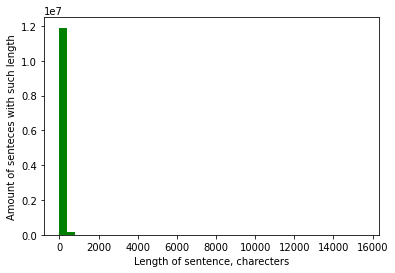

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_len_hist(stat):
    plt.hist(stat[1]['len']['eng'], 40, facecolor='g')#[x[0] for x in distr['eng']], 40, facecolor='g')
    plt.xlabel('Length of sentence, charecters')
    plt.ylabel('Amount of senteces with such length')
    plt.show()

plot_len_hist(stats_init)

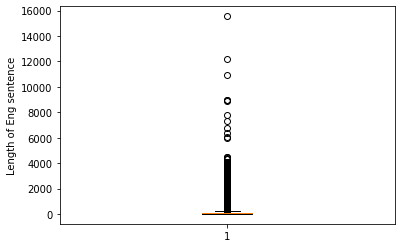

In [ ]:
def plot_counts_boxplot(stats):
    l = stats[1]['len']
    plt.boxplot(l['eng'])
    #plt.boxplot(l['rus'])
    plt.ylabel("Length of Eng sentence")
    plt.show()

plot_counts_boxplot(stats_init)

### Harsh filtering

Remove elements with links

In [ ]:
stop_chrt = ['http', 'url', 'www', 'html']
junk_elems = [(idx, sent) for lines in [lines_eng, lines_rus]
              for idx, sent in enumerate(lines) 
              if any(sw in sent for sw in stop_chrt)]
junk_elems[:20], len(junk_elems)

([(561,
   'This can be consulted on the internet: www.cathedralerussenice.org/spip/spip.php?article61. In addition, following the judgement given by the Court of Appeal in Aix-en-Provence on May 19th 2011, the Religious Association ACOR decided to take the case to the final court of appeal.\n'),
  (648,
   'To know exactly the times of the bus, follow this link: http://217.141.151.2/orari/urbani_minori/html/MAS0C.htm\n'),
  (793,
   'There will be offered four thematic sessions depending on the child’s age. A. Brodeles st., Viesite, Jekabpils novads, LV-5237, Latvija +371 65245549, +371 29116334 viesitesmuzejsselija@inbox.lv www.viestie.lt\n'),
  (812,
   'His carved sculpture of a woman was displayed in an exhibition together with M. K. Čiurlionis paintings.\n'),
  (960, 'www.koktelnieki.lv\n'),
  (1167, 'http://mp.zarabotak.com/Jeff%20Buckley.php\n'),
  (1168, 'http://mp.zarabotak.com/Catedral.php\n'),
  (1169, 'http://mp.zarabotak.com/Gary%20Burton.php\n'),
  (1170, 'http://mp.zara

In [ ]:
filtered_lines = {}
junk_idxs = set([x[0] for x in junk_elems])
for data, key in [(lines_rus, 'rus'), (lines_eng, 'eng')]:
    filtered_lines[key] = [sent for idx, sent in enumerate(data) if idx not in junk_idxs]

Lenght statistics:
Rus:{'mean': 77.41984288225754, 'argmin': 675, 'argmax': 9230692, 'min': 2, 'max': 6775}
Eng{'mean': 80.71968020958668, 'argmin': 675, 'argmax': 9230692, 'min': 2, 'max': 6775}
Rus / Eng {'mean': 1.038811039612353, 'argmin': 8540394, 'argmax': 7066074, 'min': 0.018404907975460124, 'max': 56.0}
Pairs
Smallest: ('?\n', '?\n')
Longest: ('").appendTo(this.element).addClass("ui-slider-range ui-widget-header"+(c.range==="min"c.range==="max"?" ui-slider-range-"+c.range:""))}for(var i=e.length;i"); this.handles=e.add(a(g.join("")).appendTo(d.element));this.handle=this.handles.eq(0);this.handles.add(this.range).filter("a").click(function(b){b.preventDefault()}).hover(function(){c.disableda(this).addClass("ui-state-hover")},function(){a(this).removeClass("ui-state-hover")}).focus(function(){if(c.disabled)a(this).blur();else{a(".ui-slider .ui-state-focus").removeClass("ui-state-focus");a(this).addClass("ui-state-focus")}}).blur(function(){a(this).removeClass("ui-state-focus")})

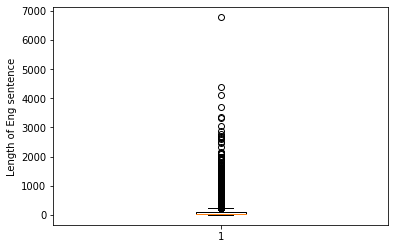

In [ ]:
stats_hard_filtered = get_statistics(filtered_lines['rus'], filtered_lines['eng'])
print(stats_hard_filtered[0])
plot_counts_boxplot(stats_hard_filtered)

In [ ]:
# Clean RAM
lines_eng = lines_rus = None

### Filter too long and too small *phrases* and bad ratio

In [ ]:
l = stats_hard_filtered[1]['len']
min_q = np.quantile(l['eng'], 0.35)
max_q = np.quantile(l['eng'], 0.65)
print(f'min_q {min_q}, max_q {max_q}')

min_q 29.0, max_q 76.0


In [ ]:
min_ratio = 1 / 2 
max_ratio = 2
ratious = stats_hard_filtered[1]['ratious']

bad_ratio_idxs = np.where((ratious < min_ratio) |
                           (ratious > max_ratio))[0]
print(f'Pairs with bad ratio: {len(bad_ratio_idxs)}')

Pairs with bad ratio: 715850


In [ ]:
def get_pair(idx):
    return filtered_lines['eng'][idx], filtered_lines['rus'][idx] 


np.random.seed(42)
print('Pairs with bad ratio examples:')
for idx in np.random.choice(bad_ratio_idxs, 10):
    print(get_pair(idx))

Pairs with bad ratio examples:
('Страницы: [1]\n', 'Страницы: 1 ... 23 24 [25] 26 27 ... 249\n')
('10\n', 'Фотографии Т-50 (10)\n')
('Branches and representative offices of international and foreign non-governmental organisations shall be governed in their activity by the Charters of such international and foreign non-governmental organisations, provided that such Charters are consistent with the legislation of the Republic of Kazakhstan.\n', 'Лица, виновные в нарушении настоящего Закона, несут ответствен-ность в соответствии с законами Республики Казахстан.\n')
('All the cartoonists whose works will be selected for the catalogue will receive a catalogue.\n', '3. По итогам конкурса будет издан каталог.\n')
('Related tags: high-tech, strategies, successful\n', 'Related tags: деньги, успех, финансы, управление, менеджмент, саморазвитие, кийосаки, предприятие, богатство, маркетинг\n')
('After brilliant performance in Budapest dzhuybarsky wrestlers met in the hometown as national heroes. 1

In [ ]:
good_ri = set(range(len(ratious))) - set(bad_ratio_idxs)

ratious[list(good_ri)].max()
for key in ['eng', 'rus']:
    filtered_lines[key] = [sent for idx, sent in enumerate(filtered_lines[key]) if idx in good_ri]

print(f'{len(bad_ratio_idxs)} elements was removed')

715850 elements was removed


In [ ]:
outlayers_idxs = {idx for lang in ['rus', 'eng']
                  for idx, data in enumerate(filtered_lines[lang])
                  if len(data) < min_q  or len(data) > max_q}

#outlayers_idxs.union(set(bad_ratio_idxs))

filtered_lines_filter_q = {}
for key, data in filtered_lines.items(): 
    filtered_lines_filter_q[key] = [sent for idx, sent in enumerate(data) 
                                    if idx not in outlayers_idxs]

print(f'{len(outlayers_idxs)} elements was removed')

7975256 elements was removed


Lenght statistics:
Rus:{'mean': 46.19948509146689, 'argmin': 83, 'argmax': 450, 'min': 29, 'max': 76}
Eng{'mean': 46.29208094422188, 'argmin': 49, 'argmax': 176, 'min': 29, 'max': 76}
Rus / Eng {'mean': 1.0159408232277127, 'argmin': 3442, 'argmax': 2570, 'min': 0.5, 'max': 2.0}
Pairs
Smallest: ('4. Parishes and Communities.\n', '4. Приходы и приходские общины.\n')
Longest: ('You will find the booking class on your ticket: where is the booking class?\n', 'Класс бронирования указан в Вашем билете: где указан класс бронирования?\n')
Smallest ratio: ('Below is the tungsten alloy radiation shielding terms and definition.\n', 'Радиационные термины и определения\n')
Biggest ratio: ("See also: I'd , I'm , i's , ism\n", 'See also: chat , ghat , hat , that , what , wheat , whet , whit\n')
Counts of pairs: 2931006


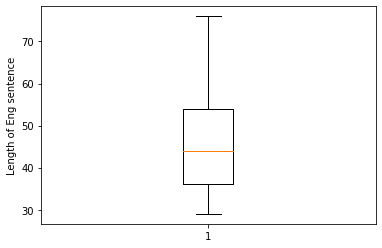

In [ ]:
stat_filtered_q = get_statistics(filtered_lines_filter_q['rus'], 
                                 filtered_lines_filter_q['eng'])
print(stat_filtered_q[0])
plot_counts_boxplot(stat_filtered_q)

GT: ('Top of performance 85 %\n', 'Максимальная яйценоскость 85 %\n'), interesting!

Looks like non translated outlayer appears in dataset, let's filter em

In [ ]:
russian_alph = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
eng_alph = 'abcdefghigklmnopqrstuvwxyz'

any_russian_ch = lambda x: any(rus_ch in x for rus_ch in russian_alph)
any_eng_ch = lambda x: any(eng_ch in x for eng_ch in eng_alph) 

non_translated_idxs = {idx for idx, data in enumerate(filtered_lines_filter_q['rus'])
                       if not any_russian_ch(data)}
language_mixed = {idx for idx, data in enumerate(filtered_lines_filter_q['eng'])
                       if any_russian_ch(data)}.union({
                           idx for idx, data in enumerate(filtered_lines_filter_q['rus'])
                           if any_eng_ch(data)
                       })
                    
outlayers = non_translated_idxs.union(language_mixed)
print(f'{len(outlayers)} non translated pairs was found')

1259522 non translated pairs was found


In [ ]:
def get_pair(idx):
    return filtered_lines_filter_q['eng'][idx], filtered_lines_filter_q['rus'][idx] 


np.random.seed(42)
print('Not translated pairs example')
for idx in np.random.choice(list(non_translated_idxs), 10):
    print(get_pair(idx))

Not translated pairs example
('« Reply #1 on: March 02, 2009, 04:25:53 PM »\n', '« Reply #1 on: December 02, 2005, 11:04:34 AM »\n')
('#24 Encuentro desconocido (00:00:43)\n', '#28 Encuentro desconocido (00:01:45)\n')
('« Reply #2 on: August 30, 2008, 10:52:13 AM »\n', '« Reply #2 on: September 20, 2007, 08:59:31 AM »\n')
('This page has been generated on Saturday, Jun 4th 2016, 14:30 pm CST\n', 'This page has been generated on Thursday, Apr 14th 2016, 22:58 pm CST\n')
('« Reply #19 on: August 03, 2009, 12:42:24 PM »\n', '« Reply #3 on: January 30, 2009, 10:09:08 AM »\n')
('17.04.2012 15:40 (0 comments)\n', '17.04.2012 15:40 (0 comments)\n')
('Poem Submitted: Tuesday, March 30, 2010\n', 'Poem Submitted: Friday, September 11, 2015\n')
('This list was generated on Sun Jun 12 10:24:31 2016 QYZT.\n', 'This list was generated on Sun Jun 12 10:01:21 2016 QYZT.\n')
('Play other great free collecting.\n', 'Play other great free collecting .\n')
('Gare de l’Est (metro line 5)\n', 'Gare de l’Est

In [ ]:
filtered_final = {}
for key, data in filtered_lines_filter_q.items(): 
    filtered_final[key] = [sent for idx, sent in enumerate(data) 
                                    if idx not in outlayers]

print(f'{len(outlayers)} elements was removed')

1259522 elements was removed


Lenght statistics:
Rus:{'mean': 46.955562242893144, 'argmin': 68, 'argmax': 274, 'min': 29, 'max': 76}
Eng{'mean': 47.32550057314339, 'argmin': 35, 'argmax': 148, 'min': 29, 'max': 76}
Rus / Eng {'mean': 1.0158406613946556, 'argmin': 1079, 'argmax': 1267, 'min': 0.5, 'max': 2.0}
Pairs
Smallest: ('4. Parishes and Communities.\n', '4. Приходы и приходские общины.\n')
Longest: ('You will find the booking class on your ticket: where is the booking class?\n', 'Класс бронирования указан в Вашем билете: где указан класс бронирования?\n')
Smallest ratio: ('Below is the tungsten alloy radiation shielding terms and definition.\n', 'Радиационные термины и определения\n')
Biggest ratio: ('Cancer (3) Apply filter: Cancer\n', 'Психическое здоровье (3) Применить фильтр: Психическое здоровье\n')
Counts of pairs: 1671484


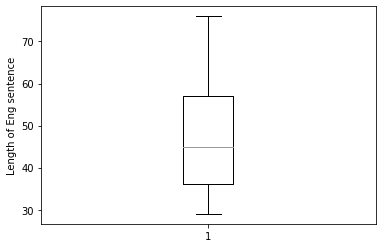

In [ ]:
stat_filtered_final = get_statistics(filtered_final['rus'], 
                                     filtered_final['eng'])
print(stat_filtered_final[0])
plot_counts_boxplot(stat_filtered_final)

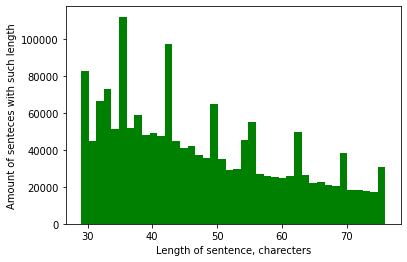

In [ ]:
plot_len_hist(stat_filtered_final)

Let's try to remove all pairs contains digits

In [ ]:
digits_in_sent = {idx for lang in ['rus', 'eng']
                  for idx, data in enumerate(filtered_final[lang]) 
                  if any(char.isdigit() for char in data)}

print(f'Count of pairs with digits: {len(digits_in_sent)}')

Count of pairs with digits: 872012


In [ ]:
filtered_small = {}
for key, data in filtered_final.items(): 
    filtered_small[key] = [sent for idx, sent in enumerate(data) 
                                    if idx not in digits_in_sent]

print(f'{len(digits_in_sent)} elements was removed')

872012 elements was removed


Lenght statistics:
Rus:{'mean': 50.46132072167631, 'argmin': 40, 'argmax': 170, 'min': 29, 'max': 76}
Eng{'mean': 51.42139937358657, 'argmin': 40, 'argmax': 96, 'min': 29, 'max': 76}
Rus / Eng {'mean': 1.0039682494935338, 'argmin': 601, 'argmax': 2710, 'min': 0.5, 'max': 2.0}
Pairs
Smallest: ('There are two possibilities:\n', 'Для этого есть два варианта:\n')
Longest: ('You will find the booking class on your ticket: where is the booking class?\n', 'Класс бронирования указан в Вашем билете: где указан класс бронирования?\n')
Smallest ratio: ('Below is the tungsten alloy radiation shielding terms and definition.\n', 'Радиационные термины и определения\n')
Biggest ratio: ('What is your position in this regard?\n', 'Что говорит Библия в этом смысле, и как мне следует поступать в дальнейшем?\n')
Counts of pairs: 799472


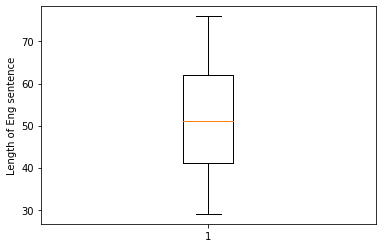

In [ ]:
stat_filtered_small = get_statistics(filtered_small['rus'], 
                                     filtered_small['eng'])
print(stat_filtered_small[0])
plot_counts_boxplot(stat_filtered_small)

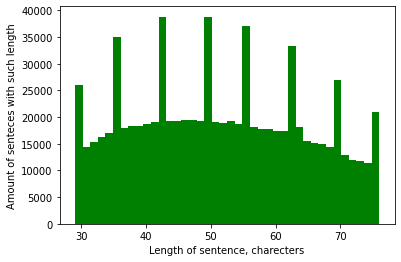

In [ ]:
plot_len_hist(stat_filtered_small)

# Part where you can save/load filtered dataset

In [ ]:
file_path = 'filtered_transl.csv'

In [ ]:
# Write filtered data
with open(file_path, "w", newline='', encoding="utf-8") as out:
        out.write(pd.DataFrame(data=filtered_small).to_csv(index=False))


In [ ]:
#@title Choose load or process filtered data 
load_data = True #@param {type:"boolean"}
if not load_data:
    lines_eng, lines_rus = filtered_lines_filter_q['eng'], filtered_lines_filter_q['rus']
else:
    # Load filtered data
    df = pd.read_csv(file_path, index_col=False)
    lines_eng, lines_rus = list(df['eng']), list(df['rus'])

In [ ]:
df

,rus,eng
0,O НАС Новости Референции Контакт\n,About us News References Contacts\n
1,Ваш комфорт - наша обязанность…\n,"Your comfort, our obligation…\n"
2,Достаточно просто попросить нас об этом.\n,All you need to do is just ask for it.\n
3,Этот автор еще не заполнил сведений о себе.\n,This author has not yet filled in any details.\n
4,"К сожалению, эта страница не найдена!\n","Oops, This Page Could Not Be Found!\n"
...,...,...
799467,Приглашения на мероприятия дипломатических мис...,Invitations to Embassy’s an Consulate’s events...
799468,Доступ к другим группам влияния + +\n,Access to members of other communities + +\n
799469,Специальная цена на рекламу на сайте РСП + -\n,Special rate for ad on RBC website + -\n
799470,Специальная цена на рекламу в журнале «Деловые...,Special rate for ad in RBC magazine + -\n


In [ ]:
# Just to check everything is loaded ok
lines_eng[:5], lines_rus[:5]

(['About us News References Contacts\n',
  'Your comfort, our obligation…\n',
  'All you need to do is just ask for it.\n',
  'This author has not yet filled in any details.\n',
  'Oops, This Page Could Not Be Found!\n'],
 ['O НАС Новости Референции Контакт\n',
  'Ваш комфорт - наша обязанность…\n',
  'Достаточно просто попросить нас об этом.\n',
  'Этот автор еще не заполнил сведений о себе.\n',
  'К сожалению, эта страница не найдена!\n'])

In [ ]:
# Take only N elements from dataset
N = 100000
lines_eng, lines_rus = lines_eng[:N], lines_rus[:N]

# Models

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List


SRC_LANGUAGE = 'eng'
TGT_LANGUAGE = 'rus'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='ru_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    for data_sample in data_iter:
        yield token_transform[language](data_sample)

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
 
for train_iter, ln in [(lines_eng, 'eng'), (lines_rus, 'rus')]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

## Seq2Seq Network using LSTM

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Seq2Seq Network using Transformer
---------------------------------

Transformer is a Seq2Seq model introduced in `“Attention is all you
need” <https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf>`__
paper for solving machine translation tasks. 
Below, we will create a Seq2Seq network that uses Transformer. The network
consists of three parts. First part is the embedding layer. This layer converts tensor of input indices
into corresponding tensor of input embeddings. These embedding are further augmented with positional
encodings to provide position information of input tokens to the model. The second part is the 
actual `Transformer <https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html>`__ model. 
Finally, the output of Transformer model is passed through linear layer
that give un-normalized probabilities for each token in the target language. 




In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network 
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

During training, we need a subsequent word mask that will prevent model to look into
the future words when making predictions. We will also need masks to hide
source and target padding tokens. Below, let's define a function that will take care of both. 




In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Let's now define the parameters of our model and instantiate the same. Below, we also 
define our loss function which is the cross-entropy loss and the optmizer used for training.




In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64 
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, 
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-7)
scheduler = ExponentialLR(optimizer, gamma=0.99) 

Collation
---------

As seen in the ``Data Sourcing and Processing`` section, our data iterator yields a pair of raw strings. 
We need to convert these string pairs into the batched tensors that can be processed by our ``Seq2Seq`` network 
defined previously. Below we define our collate function that convert batch of raw strings into batch tensors that
can be fed directly into our model.   




In [ ]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Let's define training and evaluation loop that will be called for each 
epoch.




Define iterators

In [ ]:
N_train = int(N * 0.9)

complete_ds = list(zip(lines_eng, lines_rus))
train_iter = complete_ds[:N_train]
test_iter = complete_ds[N_train:] 
N_train

90000

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    with tqdm(train_dataloader) as t:
        for src, tgt in t:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)

            tgt_input = tgt[:-1, :]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

            logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

            optimizer.zero_grad()

            tgt_out = tgt[1:, :]
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
            loss.backward()

            optimizer.step()
            losses += loss.item()
            t.set_description(f'Loss: {loss.item()}')

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE,
                                collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

Now we have all the ingredients to train our model. Let's do it!




In [ ]:
import torch
from timeit import default_timer as timer
from torch.utils.tensorboard import SummaryWriter
NUM_EPOCHS = 18

sw = SummaryWriter()
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    sw.add_scalar('Loss/train', train_loss)
    sw.add_scalar('Loss/val', val_loss)
    scheduler.step()

# Save last ckpt
PATH = 'transformer.ckpt'
torch.save(transformer.state_dict(), PATH)



# function to generate output sequence using greedy algorithm 
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

Loss: 7.437880039215088: 100%|██████████| 1407/1407 [08:28<00:00,  2.76it/s]


Epoch: 1, Train loss: 6.908, Val loss: 7.172, Epoch time = 508.925s


Loss: 6.653111934661865: 100%|██████████| 1407/1407 [08:27<00:00,  2.77it/s]


Epoch: 2, Train loss: 5.880, Val loss: 6.934, Epoch time = 507.990s


Loss: 6.099935531616211: 100%|██████████| 1407/1407 [08:27<00:00,  2.77it/s]


Epoch: 3, Train loss: 5.364, Val loss: 6.864, Epoch time = 507.735s


Loss: 5.528937816619873: 100%|██████████| 1407/1407 [08:28<00:00,  2.77it/s]


Epoch: 4, Train loss: 4.972, Val loss: 6.838, Epoch time = 508.075s


Loss: 5.236104488372803: 100%|██████████| 1407/1407 [08:30<00:00,  2.76it/s]


Epoch: 5, Train loss: 4.657, Val loss: 6.766, Epoch time = 510.297s


Loss: 4.919432640075684: 100%|██████████| 1407/1407 [08:30<00:00,  2.76it/s]


Epoch: 6, Train loss: 4.393, Val loss: 6.679, Epoch time = 510.561s


Loss: 4.658354759216309: 100%|██████████| 1407/1407 [08:30<00:00,  2.76it/s]


Epoch: 7, Train loss: 4.169, Val loss: 6.659, Epoch time = 510.627s


Loss: 4.420555114746094: 100%|██████████| 1407/1407 [08:30<00:00,  2.76it/s]


Epoch: 8, Train loss: 3.977, Val loss: 6.642, Epoch time = 510.699s


Loss: 4.295312404632568: 100%|██████████| 1407/1407 [08:30<00:00,  2.75it/s]


Epoch: 9, Train loss: 3.808, Val loss: 6.638, Epoch time = 510.903s


Loss: 4.038195610046387: 100%|██████████| 1407/1407 [08:30<00:00,  2.75it/s]


Epoch: 10, Train loss: 3.657, Val loss: 6.679, Epoch time = 510.753s


Loss: 3.890901803970337: 100%|██████████| 1407/1407 [08:30<00:00,  2.76it/s]


Epoch: 11, Train loss: 3.523, Val loss: 6.773, Epoch time = 510.696s


Loss: 3.823850393295288: 100%|██████████| 1407/1407 [08:30<00:00,  2.75it/s]


Epoch: 12, Train loss: 3.404, Val loss: 6.846, Epoch time = 510.884s


Loss: 3.6336758136749268: 100%|██████████| 1407/1407 [08:31<00:00,  2.75it/s]


Epoch: 13, Train loss: 3.291, Val loss: 7.028, Epoch time = 511.612s


Loss: 3.481980800628662: 100%|██████████| 1407/1407 [08:31<00:00,  2.75it/s]


Epoch: 14, Train loss: 3.190, Val loss: 7.228, Epoch time = 511.956s


Loss: 3.4601991176605225: 100%|██████████| 1407/1407 [08:32<00:00,  2.75it/s]


Epoch: 15, Train loss: 3.100, Val loss: 7.111, Epoch time = 512.285s


Loss: 3.3359272480010986: 100%|██████████| 1407/1407 [08:31<00:00,  2.75it/s]


Epoch: 16, Train loss: 3.012, Val loss: 6.949, Epoch time = 511.764s


Loss: 3.338839054107666: 100%|██████████| 1407/1407 [08:31<00:00,  2.75it/s]


Epoch: 17, Train loss: 2.925, Val loss: 6.891, Epoch time = 511.369s


Loss: 3.165442705154419: 100%|██████████| 1407/1407 [08:29<00:00,  2.76it/s]


Epoch: 18, Train loss: 2.847, Val loss: 6.968, Epoch time = 509.465s


In [ ]:
print(translate(transformer, "I love you"))

 Я люблю вас 


In [15]:
print(translate(transformer, "This is success"))

 Это успех , это успех 


In [16]:
print(translate(transformer, 'Where is a bathroom'))

 Где есть ванная комната 


In [19]:
print(translate(transformer, 'Sad teddy bear'))

 ЦИК подал отчет в отношении 


In [18]:
print(translate(transformer, 'I hate you'))

 Я не люблю вас 


In [23]:
print(translate(transformer, 'How can I pay for this?'))

 Как я могу платить за это ? 


In [25]:
print(translate(transformer, 'Do you want to play a game with me?'))

 Вы хотите играть в игре с меня ? 


In [26]:
print(translate(transformer, 'How can you really?'))

 Как вы можете действительно ? 


In [38]:
print(translate(transformer, 'I love Valdimir Putin'))

 Я люблю СМИ 


In [41]:
print(translate(transformer, 'What is the strength in, brother?'))

 Что такое сила , брат , с которого нет силы ? 


In [44]:
print(translate(transformer, 'As far as I know he didn\'t take your keys'))

 Как я не знаю , он не получил свою партия 


Kind of working !!!

References
----------

1. Attention is all you need paper.
   https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
2. The annotated transformer. https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding

